In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

In [37]:
def imageCaption(image, encoder_path='./models/encoder-5-3000.pkl', decoder_path='./models/decoder-5-3000.pkl', 
                     vocabulary_path='./data/vocab.pkl', crop_size=224, embed_size=256, hidden_size=512, num_layers=1):
    '''
    :param image: the image for generating captions
    :param encoder_path: trainer encoder path
    :param decoder_path: trainer decoder path
    :param vocabulary_path: vacabulary wrapper path
    :param crop_size: size for center cropping images
    :param embed_size: dimension of word embedding vectors
    :param hidden_size: dimension of lstm hidden states
    :param num_layers: number of layers in lstm
    :return: 
    '''
    ## image transform parameter
    transform = transforms.Compose([ 
        transforms.Resize(crop_size),  
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    ## load vocabulary wrapper
    with open(vocabulary_path, 'rb') as f:
        vocab = pickle.load(f)
        
    ## Establish model
    encoder = EncoderCNN(embed_size)
    encoder.eval()  # evaluation mode (BN uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    
    # Load trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    
    # Load Image       
    image = Image.open(image)
    image_tensor = Variable(transform(image).unsqueeze(0))
    
    # LSTM initial states
    state = (Variable(torch.zeros(num_layers, 1, hidden_size)),
             Variable(torch.zeros(num_layers, 1, hidden_size)))
    
    # If use gpu
    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()
        state = [s.cuda() for s in state]
        image_tensor = image_tensor.cuda()
    
    # Generate caption from image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature, state)
    sampled_ids = sampled_ids.cpu().data.numpy()
    
    # Decode word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    sentence = sentence[8: -6] ## remove <start> <end>
    
    # Print out image and generated caption.
    plt.imshow(np.asarray(image))
    print (sentence)

a clock is on the side of a building .


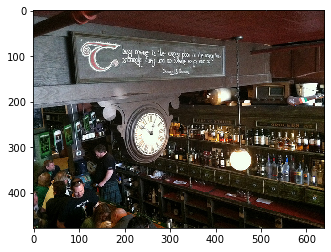

In [39]:
imageCaption(image="./test/COCO_val2014_000000581632.jpg")